In [1]:
from ast import literal_eval
from matplotlib.pyplot import subplots, savefig
from numpy import array, max as max_np
from pandas import read_csv, DataFrame
from seaborn import scatterplot, regplot, boxplot, violinplot


# df = read_csv('~/workspace/work/pypuf/results/ipuf.custom_layer_attack_simple.csv')
df = read_csv('~/workspace/work/pypuf/results/ipuf.custom_layer_attack_heuristics.csv')

# errors: layer, chains_up, chains_down
k_up = df['k_up'][0]
k_down = df['k_down'][0]
upper = f'cross_correlation_upper'
lower = f'cross_correlation_lower'
upper_rel = f'cross_correlation_rel_upper'
lower_rel = f'cross_correlation_rel_lower'

layer_kinds = [f'{layer}{kind}' for layer in ['upper', 'lower'] for kind in ['', '_rel']]
correlations = [f'correlations_{layer_kind}' for layer_kind in layer_kinds]
errors = [f'error_{kind}_{layer}' for layer in ['upper', 'lower'] for kind in ['1', '2']]
properties = ['k_up', 'k_down', 'layer', 'remove_error_1', 'remove_error_2', 'separate']
columns = correlations + errors + properties + ['fitnesses'] + ['heuristic'] + ['ts_ratios']
data = DataFrame(columns=columns)

for i in range(len(df)):
    errors_1 = literal_eval(df.error_1[i])
    errors_2 = literal_eval(df.error_2[i])
    d = {
            correlations[0]: list(max_np(abs(array(literal_eval(df[upper][i]))), axis=0)),
            correlations[1]: list(max_np(abs(array(literal_eval(df[upper_rel][i]))), axis=0)),
            correlations[2]: list(max_np(abs(array(literal_eval(df[lower][i]))), axis=0)),
            correlations[3]: list(max_np(abs(array(literal_eval(df[lower_rel][i]))), axis=0)),
            errors[0]: errors_1[1: -k_down],
            errors[1]: errors_2[1: -k_down],
            errors[2]: errors_1[1 + k_up:],
            errors[3]: errors_2[1 + k_up:],
        }
    d.update({prop: df[prop][i] for prop in properties})
    d.update({'fitnesses': literal_eval(df['fitnesses'][i]), 'heuristic': str(df['heuristic'][i]), 'ts_ratios': str(df['ts_ratios'][i])})
    row = DataFrame(d)
    data = data.append(other=row, ignore_index=True)

In [ ]:
nrows = 2
ncols = 2
fig, axes = subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
separate = False
layer = 'upper'
heuristic = data[data['layer'] == layer]['heuristic'].iloc[0]
jitter = 0.01
filtered_data = data[
    (data['separate'] == separate) &
    (data['layer'] == layer)
]

for i in range(nrows):
    for j in range(ncols):
        axes[j, i].set_ylim([-0.05, 1.05])
        kind = '' if i == 0 else '_rel'
        for rm_error_1 in [True, False]:
            for rm_error_2 in [True, False]:
                l = "remove e1, e2" if rm_error_1 and rm_error_2 \
                else "remove e1" if rm_error_1 \
                else "remove e2" if rm_error_2 \
                else "no removal"
                regplot(
                    x=filtered_data[
                        (filtered_data['remove_error_1'] == rm_error_1) &
                        (filtered_data['remove_error_2'] == rm_error_2)][f'error_{j + 1}_{layer}'
                    ],
                    y=filtered_data[
                        (filtered_data['remove_error_1'] == rm_error_1) &
                        (filtered_data['remove_error_2'] == rm_error_2)][f'correlations_{layer}{kind}'
                    ],
                    ci=0,
                    ax=axes[j, i],
                    label=l,
                    scatter_kws={'alpha':0.5},
                    y_jitter=jitter,
                )
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', framealpha=0.7)
fig.suptitle(f'Learning quality of particular LTF chains of the {layer} layer of different (3,3)-iPUFs '
             f'measured by correlation.\nThe training set was built using '
             f'{"fresh CRPs on the layer" if separate else f"the heuristic {heuristic} (unrel : s, s_swap, rel: s, s_swap; True=rel)"}.\n'
             f'A jitter effect (random noise of standard deviation = {jitter}) was applied to make concealed points visible.')
savefig(fname=f'figures/rel-based_attack_on_ipuf_{layer}_chains_statistics{"_separate" if separate else ""}.pdf', dpi=300)

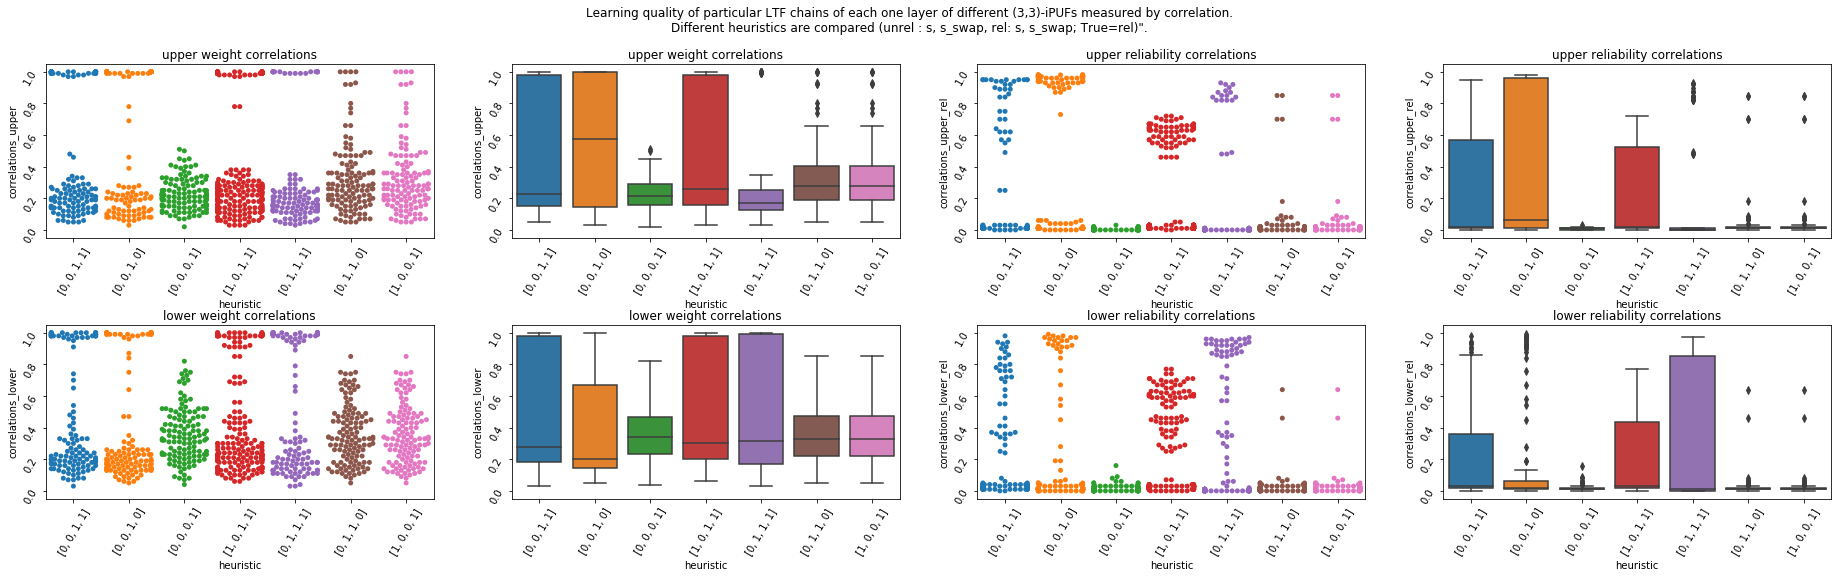

In [37]:
from seaborn import swarmplot
nrows = 2
ncols = 4
fig, axes = subplots(nrows=nrows, ncols=ncols, figsize=(32, 8))
separate = False
filtered_data = data[
    (data['separate'] == separate)
]

for i, layer in enumerate(['upper', 'lower']):
    for j in range(ncols):
        axes[i, j].set_ylim([-0.05, 1.05])
        swarmplot(
            x='heuristic',
            y=f'correlations_{layer}{"" if j < 2 else "_rel"}',
            data=filtered_data,
            ax=axes[i, j],
        ) if j % 2 == 0 else boxplot(
            x='heuristic',
            y=f'correlations_{layer}{"" if j < 2 else "_rel"}',
            data=filtered_data,
            ax=axes[i, j],
        )
        axes[i, j].set_title(f'{layer} {"weight" if j < 2 else "reliability"} correlations')
        axes[i, j].tick_params(labelrotation=60)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Learning quality of particular LTF chains of each one layer of different (3,3)-iPUFs measured by '
             'correlation.\nDifferent heuristics are compared (unrel : s, s_swap, rel: s, s_swap; True=rel)".\n')
savefig(fname='figures/rel-based_attack_on_ipuf_layer_chains_heuristics.pdf', dpi=300)